In [1]:
# Import dependencies
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import os
import pandas as pd
from pprint import pprint
import billboard
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from config import client_id, client_secret, redirect_uri, username
import numpy as np

In [2]:
# Boiler plate code to authenticate Spotify API
os.environ['SPOTIPY_CLIENT_ID']= client_id
os.environ['SPOTIPY_CLIENT_SECRET']= client_secret
os.environ['SPOTIPY_REDIRECT_URI']= redirect_uri

client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'user-library-read playlist-read-private'
token = util.prompt_for_user_token(username, scope)
if token:
   sp = spotipy.Spotify(auth=token)
else:
   print("Can't get token for", username)

In [3]:
hot_chart = billboard.ChartData('hot-100')
country_chart = billboard.ChartData('country-songs')
rap_chart = billboard.ChartData('rap-songs')

In [4]:
# Define function to retrieve data from Billboard charts
def ChartMusic(chart):
    artists = []
    songs = []
    weeks=[]
    for song in chart:
        artists.append(song.artist)
        songs.append(song.title)
        weeks.append(song.weeks)
        
    return(artists, songs)

In [5]:
# Get Data from Billboard charts
hot_artist = []
hot_songs =  []
country_artists=[]
country_songs=[]
rap_artists=[]
rap_songs=[]

hot_artist, hot_songs = ChartMusic(hot_chart)
country_artists, country_songs = ChartMusic(country_chart)
rap_artists, rap_songs = ChartMusic(rap_chart)

In [6]:
# Verify length of list
print(len(hot_artist))

100


In [7]:
# Define function to get spotify track info from song names on the list
def get_track_info(song_list):
    '''Takes a list of song names and searches spotify for their track information. Returns a DF containing this info'''
    track_info = []
    for song_name in song_list:
        info=sp.search(q=song_name, type='track')['tracks']['items'][0]
        track_info.append(info)
        
    # make a pandas df of the responses
    df = pd.DataFrame(track_info)
    
    # Drop Columns that make the datat look messy
    columns_to_drop = ['album', 'artists', 'available_markets', 'external_ids', 'external_urls', 'href', 'uri', 'type', 'duration_ms']
    df_clean = df.drop(columns=columns_to_drop)
    # pprint(info)
    return(df_clean)

In [8]:
# Define a function to get the high-level feature analysis from spotify for each track id
def feature_analyzer(track_ids):
    '''Takes a list of track ids and calls the Spotify API for audio feature analysis. Returns a DF of the analyis'''
    features_list = []

    for track_id in track_ids:
        features = sp.audio_features(tracks=track_id)[0]
        features_list.append(features)
    
    df = pd.DataFrame(features_list)
    # Drop Columns that make the datat look messy
    columns_to_drop = ['analysis_url', 'track_href', 'type', 'uri']
    df_clean = df.drop(columns=columns_to_drop)
    return(df_clean)

In [9]:
# Get hot-100 billbaord data, print df to verify
hot_track_df = get_track_info(hot_songs)
hot_track_df.head()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number
0,1,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1
1,1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,97,None,3
2,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9
3,2,True,2G7V7zsVDxg1yRsu7Ew9RJ,False,In My Feelings,100,None,9
4,1,True,1jo3TwNGCXfNdB5uba3ZVv,False,Killshot,90,None,1


In [10]:
# Get hot-100 song analysis
hot_features = feature_analyzer(hot_track_df['id'])
hot_features.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.5680,0.851,235545,0.541,6FRLCMO5TUHTexlWo8ym1W,0.00000,0,0.130,-6.825,1,0.0505,124.959,4,0.448
1,0.3490,0.511,239836,0.566,0s3nnoMeVWz3989MkNQiRf,0.00000,6,0.340,-7.230,0,0.2000,83.903,4,0.218
2,0.3540,0.680,231267,0.563,7dt6x5M1jzdTEt8oCbisTK,0.00000,10,0.136,-5.843,1,0.0454,145.028,4,0.374
3,0.0589,0.835,217925,0.626,2G7V7zsVDxg1yRsu7Ew9RJ,0.00006,1,0.396,-5.833,1,0.1250,91.030,4,0.350
4,0.0989,0.892,253580,0.651,1jo3TwNGCXfNdB5uba3ZVv,0.00000,0,0.371,-8.645,0,0.3780,105.814,4,0.599


In [11]:
# Merge data frames together on id
hot_df = pd.merge(hot_track_df, hot_features, how='outer', on='id')
hot_df['genre']='hot-100'
hot_df.head()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,1,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1,0.568,0.851,...,0.0,0,0.130,-6.825,1,0.0505,124.959,4,0.448,hot-100
1,1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,97,None,3,0.349,0.511,...,0.0,6,0.340,-7.230,0,0.2000,83.903,4,0.218,hot-100
2,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9,0.354,0.680,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100
3,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9,0.354,0.680,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100
4,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9,0.354,0.680,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100


In [12]:
# Track info for Country
country_track_df = get_track_info(country_songs)
country_track_df.head()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number
0,1,False,7iDa6hUg2VgEL1o1HjmfBn,False,Meant to Be (feat. Florida Georgia Line),88,https://p.scdn.co/mp3-preview/8965aca26c5af239...,6
1,1,False,1co0puPTYvqAdUEjFOjne9,False,Simple,82,None,1
2,1,False,7Il2yWQmsqKgSkLQvHTPUI,False,Tequila,80,https://p.scdn.co/mp3-preview/87979ad13f81aa74...,1
3,1,False,698eQRku24PIYPQPHItKlA,False,She Got the Best of Me,79,https://p.scdn.co/mp3-preview/2c94e74aa5122c6e...,17
4,1,False,1HXy5I3HTWq8OvxCn0z7G7,False,Heaven,82,https://p.scdn.co/mp3-preview/6bdb8646df7ad70b...,15


In [13]:
# Audio analyis for country
country_features = feature_analyzer(country_track_df['id'])
country_features.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0470,0.643,163870,0.783,7iDa6hUg2VgEL1o1HjmfBn,0.0,10,0.083,-6.458,1,0.0856,154.084,4,0.579
1,0.0848,0.375,185200,0.889,1co0puPTYvqAdUEjFOjne9,0.0,3,0.136,-3.704,1,0.0991,199.669,4,0.881
2,0.0292,0.474,195987,0.594,7Il2yWQmsqKgSkLQvHTPUI,0.0,11,0.133,-5.756,1,0.0289,86.131,4,0.503
3,0.0292,0.533,183160,0.907,698eQRku24PIYPQPHItKlA,0.0,11,0.386,-3.793,1,0.0406,150.990,4,0.700
4,0.2630,0.677,179507,0.556,1HXy5I3HTWq8OvxCn0z7G7,0.0,9,0.105,-6.544,1,0.0306,80.009,4,0.521


In [14]:
# Merge Country
country_df = pd.merge(country_track_df, country_features, how='outer', on='id')
country_df['genre']='country'
country_df.head()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,1,False,7iDa6hUg2VgEL1o1HjmfBn,False,Meant to Be (feat. Florida Georgia Line),88,https://p.scdn.co/mp3-preview/8965aca26c5af239...,6,0.0470,0.643,...,0.0,10,0.083,-6.458,1,0.0856,154.084,4,0.579,country
1,1,False,1co0puPTYvqAdUEjFOjne9,False,Simple,82,None,1,0.0848,0.375,...,0.0,3,0.136,-3.704,1,0.0991,199.669,4,0.881,country
2,1,False,7Il2yWQmsqKgSkLQvHTPUI,False,Tequila,80,https://p.scdn.co/mp3-preview/87979ad13f81aa74...,1,0.0292,0.474,...,0.0,11,0.133,-5.756,1,0.0289,86.131,4,0.503,country
3,1,False,698eQRku24PIYPQPHItKlA,False,She Got the Best of Me,79,https://p.scdn.co/mp3-preview/2c94e74aa5122c6e...,17,0.0292,0.533,...,0.0,11,0.386,-3.793,1,0.0406,150.990,4,0.700,country
4,1,False,1HXy5I3HTWq8OvxCn0z7G7,False,Heaven,82,https://p.scdn.co/mp3-preview/6bdb8646df7ad70b...,15,0.2630,0.677,...,0.0,9,0.105,-6.544,1,0.0306,80.009,4,0.521,country


In [15]:
# Track info for Rap
rap_tracks_df = get_track_info(rap_songs)
rap_tracks_df.head()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number
0,1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,97,None,3
1,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9
2,2,True,2G7V7zsVDxg1yRsu7Ew9RJ,False,In My Feelings,100,None,9
3,1,True,1jo3TwNGCXfNdB5uba3ZVv,False,Killshot,90,None,1
4,1,True,2xLMifQCjDGFmkHkpNLD9h,False,SICKO MODE,97,https://p.scdn.co/mp3-preview/1c3c01c64477b356...,3


In [16]:
# Audio analysis fo rap
rap_features = feature_analyzer(rap_tracks_df['id'])
rap_features.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.34900,0.511,239836,0.566,0s3nnoMeVWz3989MkNQiRf,0.00000,6,0.340,-7.230,0,0.2000,83.903,4,0.218
1,0.35400,0.680,231267,0.563,7dt6x5M1jzdTEt8oCbisTK,0.00000,10,0.136,-5.843,1,0.0454,145.028,4,0.374
2,0.05890,0.835,217925,0.626,2G7V7zsVDxg1yRsu7Ew9RJ,0.00006,1,0.396,-5.833,1,0.1250,91.030,4,0.350
3,0.09890,0.892,253580,0.651,1jo3TwNGCXfNdB5uba3ZVv,0.00000,0,0.371,-8.645,0,0.3780,105.814,4,0.599
4,0.00513,0.834,312820,0.730,2xLMifQCjDGFmkHkpNLD9h,0.00000,8,0.124,-3.714,1,0.2220,155.008,4,0.446


In [17]:
# Merge rap
rap_df = pd.merge(rap_tracks_df, rap_features, how='outer', on='id')
rap_df['genre']='rap'
rap_df.head()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,97,None,3,0.34900,0.511,...,0.00000,6,0.340,-7.230,0,0.2000,83.903,4,0.218,rap
1,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9,0.35400,0.680,...,0.00000,10,0.136,-5.843,1,0.0454,145.028,4,0.374,rap
2,2,True,2G7V7zsVDxg1yRsu7Ew9RJ,False,In My Feelings,100,None,9,0.05890,0.835,...,0.00006,1,0.396,-5.833,1,0.1250,91.030,4,0.350,rap
3,1,True,1jo3TwNGCXfNdB5uba3ZVv,False,Killshot,90,None,1,0.09890,0.892,...,0.00000,0,0.371,-8.645,0,0.3780,105.814,4,0.599,rap
4,1,True,2xLMifQCjDGFmkHkpNLD9h,False,SICKO MODE,97,https://p.scdn.co/mp3-preview/1c3c01c64477b356...,3,0.00513,0.834,...,0.00000,8,0.124,-3.714,1,0.2220,155.008,4,0.446,rap


In [18]:
# Merge all generes into 1 df
all_genres_df=pd.concat([hot_df, country_df, rap_df], axis=0)
all_genres_df.tail()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
20,1,True,5DfWF0jqMgZDCiu9zJENTA,False,Ring (feat. Kehlani),83,https://p.scdn.co/mp3-preview/276c750346704cbe...,8,0.049,0.767,...,0.000000,1,0.1150,-7.881,0,0.1030,106.029,4,0.485,rap
21,1,True,0JP9xo3adEtGSdUEISiszL,False,Moonlight,95,None,3,0.556,0.921,...,0.004040,9,0.1020,-5.723,0,0.0804,128.009,4,0.711,rap
22,1,True,17jeLyQcEUmKv3MXeEo79k,False,Smile (Living My Best Life) (feat. Snoop Dogg ...,77,https://p.scdn.co/mp3-preview/f3d0c9e53a8b7fba...,1,0.090,0.874,...,0.000006,8,0.0759,-7.689,1,0.0777,98.970,4,0.427,rap
23,1,False,07FkzikE6FuHIa8Ma7zJGc,False,Lie,83,None,13,0.161,0.753,...,0.000000,5,0.2360,-6.542,1,0.1330,95.003,4,0.182,rap
24,1,True,33tNYw9oMtSkGe27NpgS64,False,W O R K I N M E,86,None,1,0.182,0.790,...,0.000007,8,0.3380,-4.055,1,0.1420,170.023,4,0.267,rap


In [19]:
# T test for country vs rap popularity
stats.ttest_ind(country_track_df['popularity'], rap_tracks_df['popularity'])

Ttest_indResult(statistic=-10.881809970330936, pvalue=6.14946668928311e-17)

In [20]:
# T test for country vs rap speechiness
stats.ttest_ind(country_features['speechiness'], rap_features['speechiness'])

Ttest_indResult(statistic=-7.086840134310077, pvalue=7.188319018189496e-10)

In [21]:
# T test for valence country vs hot 100 valence
stats.ttest_ind(country_df['valence'], hot_df['valence'])

Ttest_indResult(statistic=3.919167371328103, pvalue=0.00013399458553930443)

In [24]:
def musicScatPlotter(x_variable, y_variable):
    '''Takes the column names of the variables you want to plot as strings and makes a scatter plot. 
    It compares those relations ships for the Billboard Hot-100, Country, and Rap Charts.'''
    alpha=0.9
    plt.figure(dpi=200)
    plt.scatter(x=hot_df[x_variable], y=hot_df[y_variable], c='lightsalmon', edgecolors='k', alpha=alpha)
    plt.scatter(x=country_df[x_variable], y=country_df[y_variable], c='cornflowerblue', marker='s', edgecolors='k', alpha=alpha)
    plt.scatter(x=rap_df[x_variable], y=rap_df[y_variable], c='lightgray', marker='D', edgecolors='k', alpha=alpha)
    plt.xlabel(x_variable.title())
    plt.ylabel(y_variable.title())
    plt.legend(['Hot-100','Country','Rap'], loc='best')
    title = f'{y_variable.title()} vs {x_variable.title()}'
    plt.title(f'{title}')
    # Save figure
    plt.savefig(f'Images/{title}.png')

In [25]:
# Print the columns to see what relationships we can explore
hot_df.columns

Index(['disc_number', 'explicit', 'id', 'is_local', 'name', 'popularity',
       'preview_url', 'track_number', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'genre'],
      dtype='object')

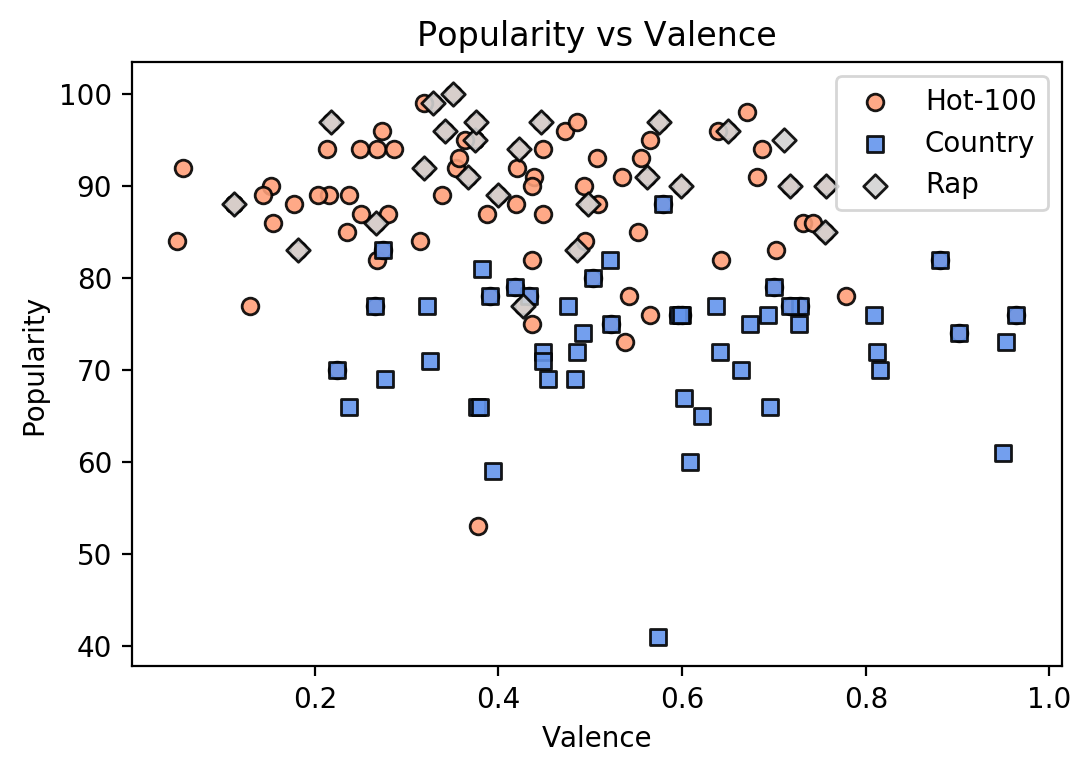

In [26]:
# Valence vs Popularity
musicScatPlotter('valence', 'popularity')

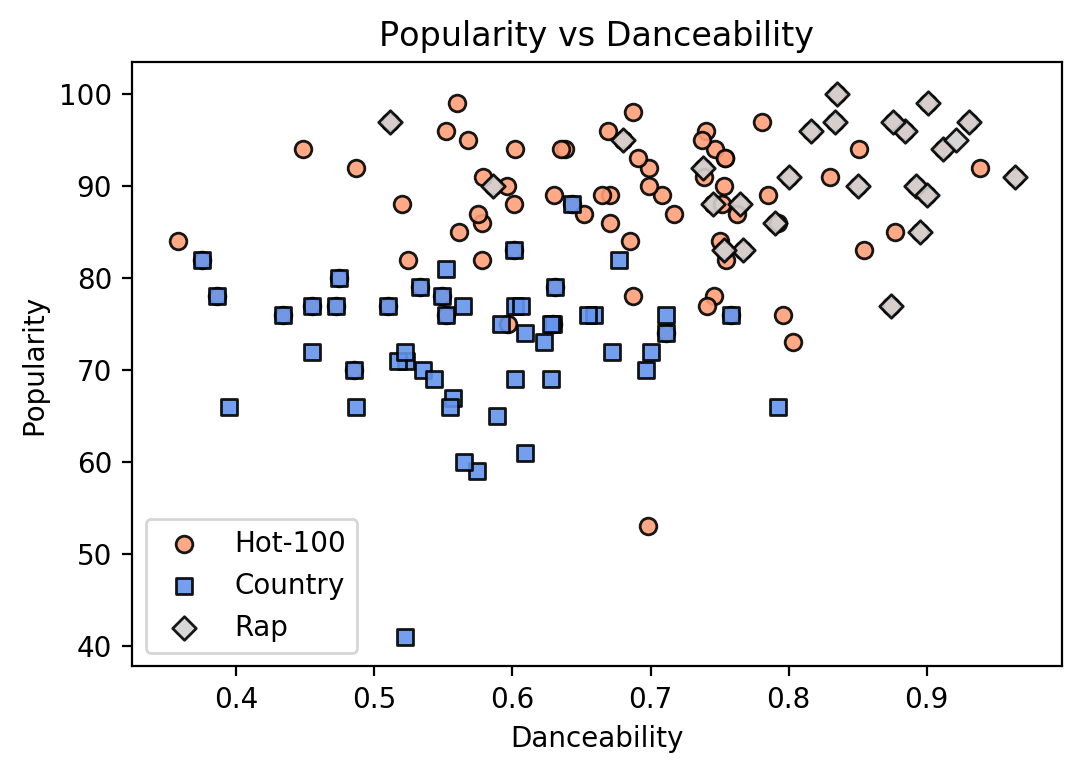

In [27]:
# Danceability vs Popularity
musicScatPlotter('danceability', 'popularity')
# plt.ylim(0)

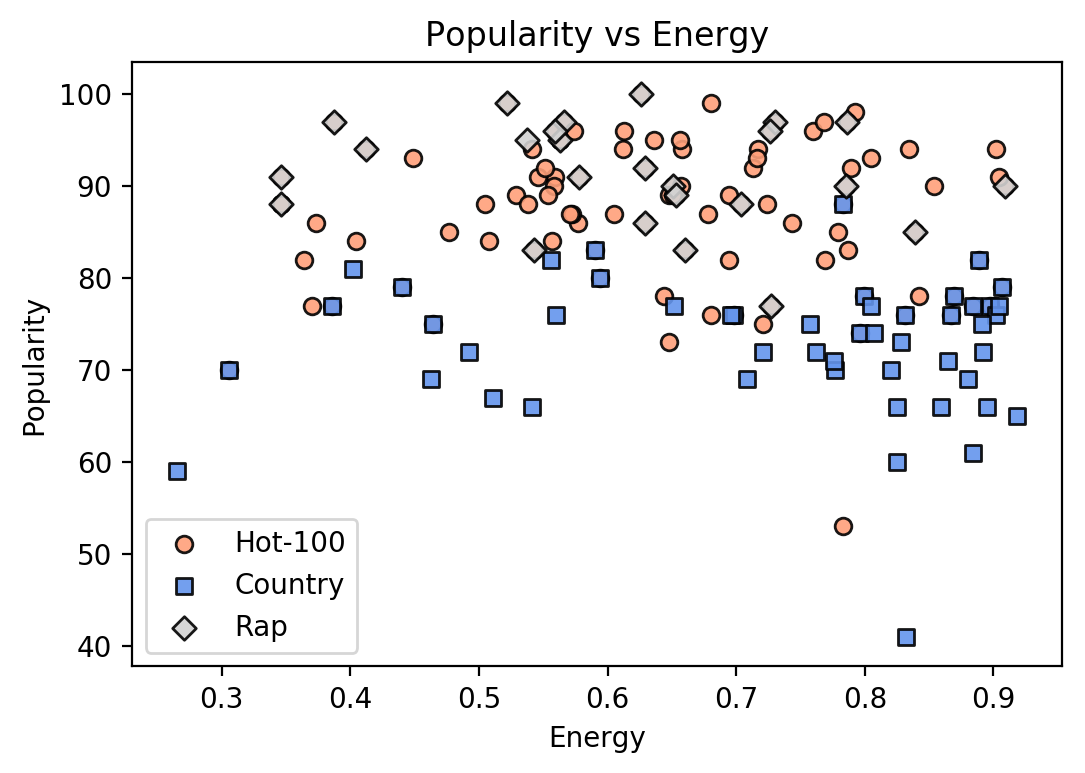

In [28]:
musicScatPlotter('energy', 'popularity')

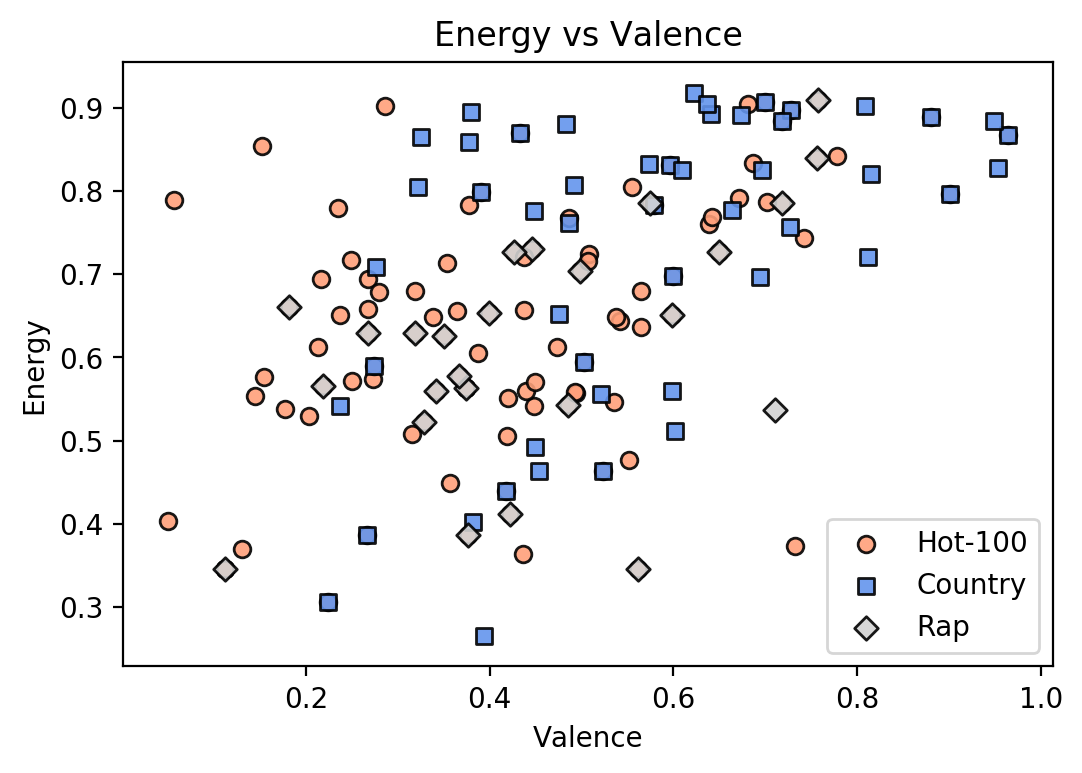

In [29]:
musicScatPlotter('valence', 'energy')

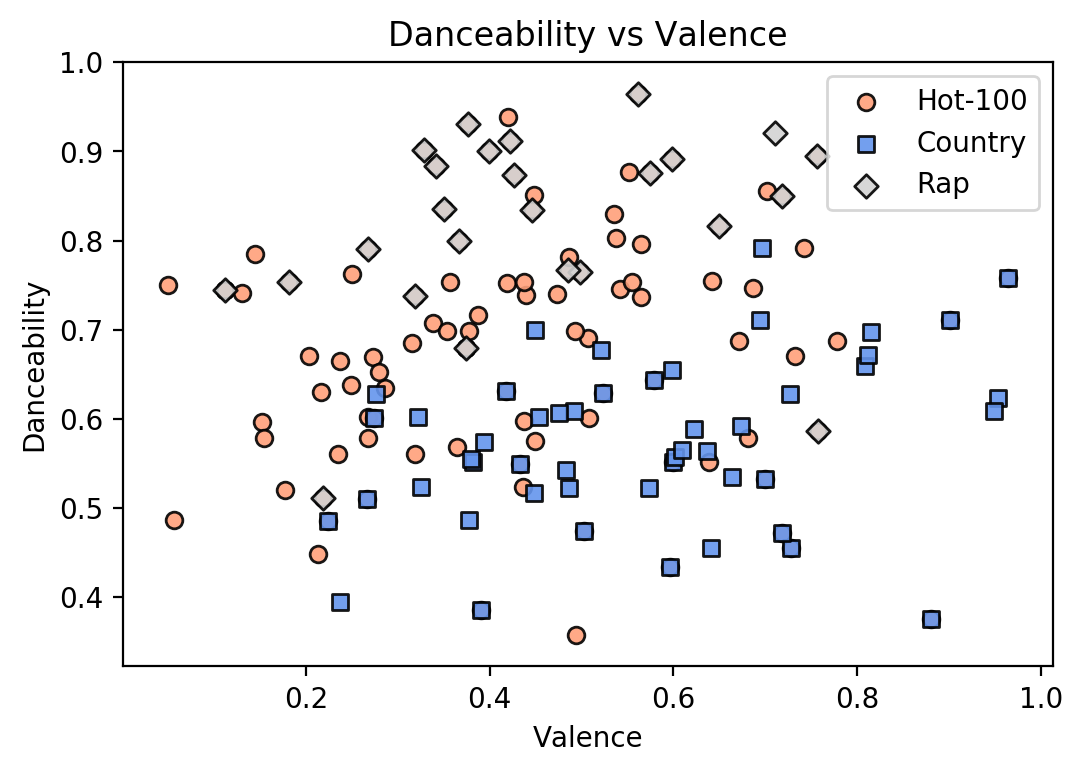

In [30]:
musicScatPlotter('valence', 'danceability')

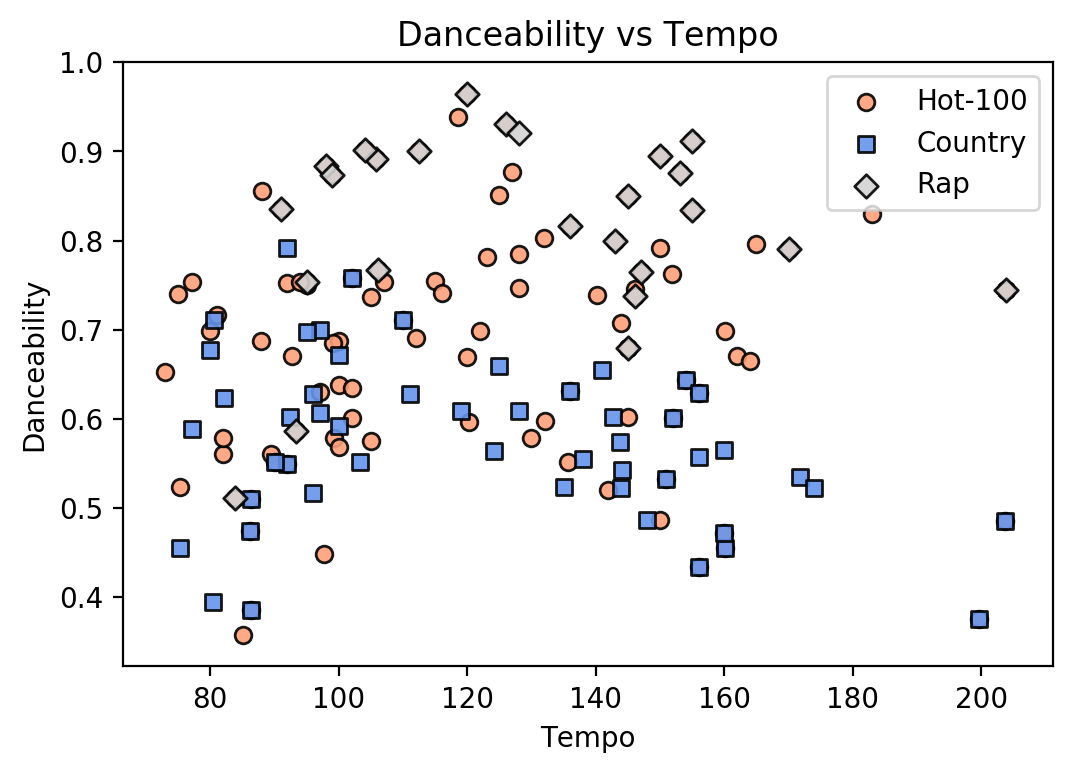

In [31]:
musicScatPlotter('tempo', 'danceability')

In [32]:
# Which is more Danceable?
genre_means = all_genres_df.groupby('genre').mean()
genre_se = all_genres_df.groupby('genre').sem()
genre_means

,disc_number,explicit,is_local,popularity,track_number,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
genre,,,,,,,,,,,,,,,,,,
country,1.000000,0.060000,0.0,72.760000,4.380000,0.193482,0.574300,203743.900000,0.725420,0.000296,6.580000,0.171530,-5.417520,0.900000,0.053522,122.620100,4.000000,0.565560
hot-100,1.019231,0.548077,0.0,87.259615,3.798077,0.182076,0.690365,213319.740385,0.638808,0.000286,5.548077,0.163096,-6.148356,0.711538,0.133388,124.650971,4.019231,0.431849
rap,1.080000,0.960000,0.0,91.440000,3.520000,0.119046,0.816800,215218.360000,0.616520,0.000735,4.760000,0.212760,-6.381120,0.520000,0.197800,128.474120,4.000000,0.449640


In [33]:
# Anova for danceability
stats.f_oneway(hot_df['danceability'], country_df['danceability'], rap_df['danceability'])

F_onewayResult(statistic=34.91595688287129, pvalue=1.6941337881835844e-13)

In [34]:
# Anova for valence
stats.f_oneway(hot_df['valence'], country_df['valence'], rap_df['valence'])

F_onewayResult(statistic=8.060730117373621, pvalue=0.0004471337243690721)

In [35]:
genres= []
for genre in genre_means.index:
    genres.append(genre.title())
    print(genre)

country
hot-100
rap


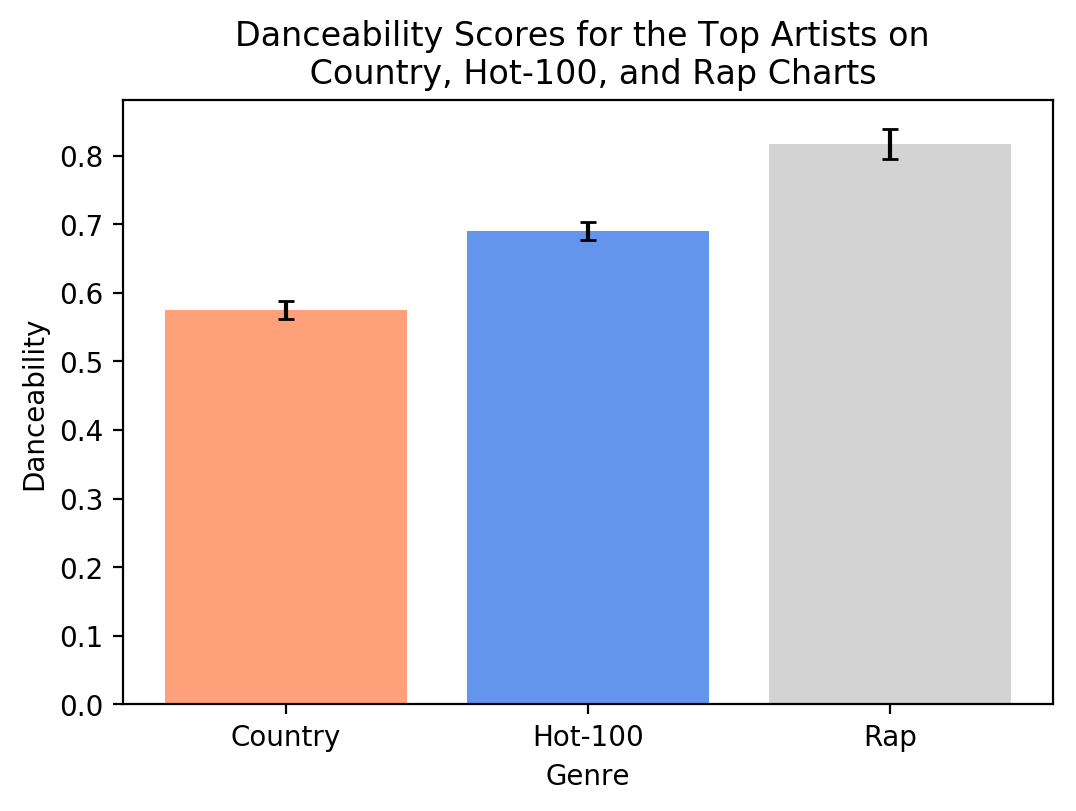

In [36]:
# Plot bar graph
plt.figure(dpi=200)
plt.bar(x=genres, height=genre_means['danceability'], yerr=genre_se['danceability'], color=['lightsalmon','cornflowerblue','lightgray'], capsize=3)
plt.ylabel('Danceability')
plt.xlabel('Genre')
plt.title('Danceability Scores for the Top Artists on \n Country, Hot-100, and Rap Charts')
plt.savefig('Images/Genre_Danceability_Bar_Chart.png')


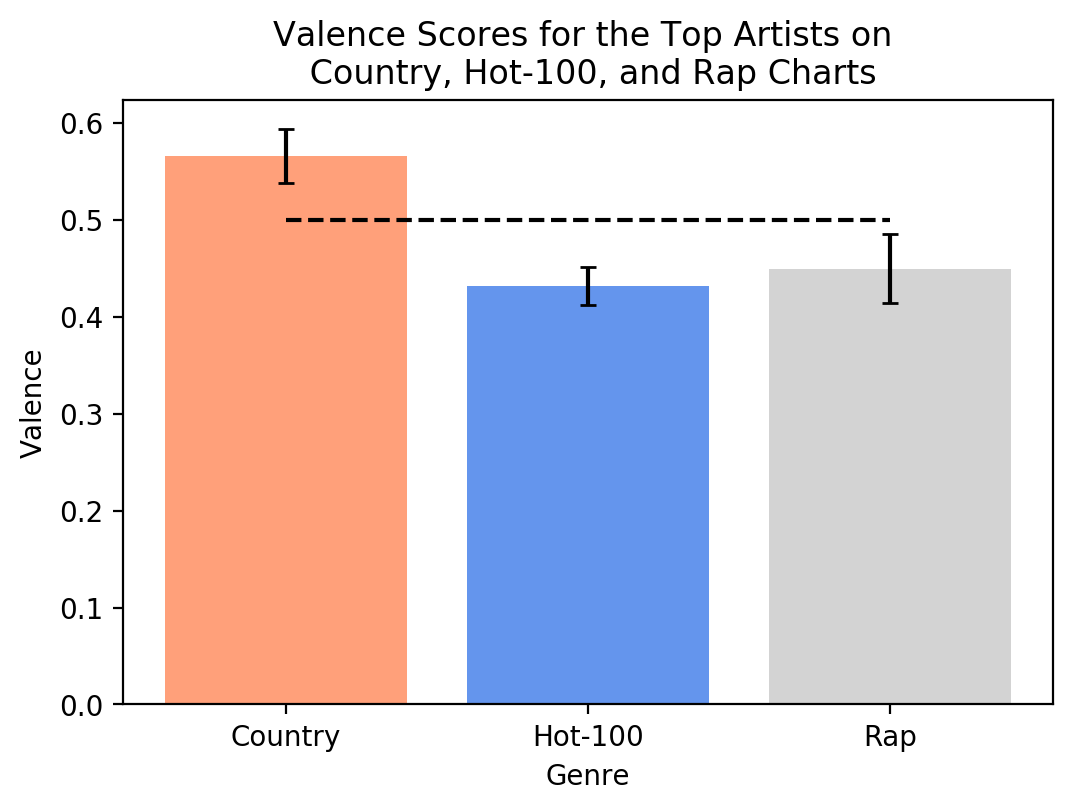

In [37]:
# Plot bar graph for valence
plt.figure(dpi=200)
plt.bar(x=genres, height=genre_means['valence'], yerr=genre_se['valence'], color=['lightsalmon','cornflowerblue','lightgray'], capsize=3)
plt.ylabel('Valence')
plt.xlabel('Genre')
plt.title('Valence Scores for the Top Artists on \n Country, Hot-100, and Rap Charts')
plt.hlines(y=0.5, xmin=0, xmax=2, linestyles='--', label='Neutral Line')
plt.savefig('Images/Genre_Valence_Bar_Chart.png')


In [38]:
# Define a list to of all the note names in the Western music system
key_names = ['C', 'C\u266F/D\u266D', 'D', 'D\u266F/E\u266D',
           'E', 'F', 'F\u266F/G\u266D', 'G', 'G\u266F/A\u266D',
           'A', 'A\u266F/B\u266D', 'B']
print(key_names)

['C', 'C♯/D♭', 'D', 'D♯/E♭', 'E', 'F', 'F♯/G♭', 'G', 'G♯/A♭', 'A', 'A♯/B♭', 'B']


In [39]:
# Define new column to get the actual key names
all_genres_df['key name'] = [key_names[key] for key in all_genres_df['key']]
all_genres_df.head()

,disc_number,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre,key name
0,1,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1,0.568,0.851,...,0,0.130,-6.825,1,0.0505,124.959,4,0.448,hot-100,C
1,1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,97,None,3,0.349,0.511,...,6,0.340,-7.230,0,0.2000,83.903,4,0.218,hot-100,F♯/G♭
2,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9,0.354,0.680,...,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100,A♯/B♭
3,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9,0.354,0.680,...,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100,A♯/B♭
4,1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,95,None,9,0.354,0.680,...,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100,A♯/B♭


In [40]:
# Groupby Count to get the NUmbder of songs in each Key
genreKeys = all_genres_df[['key name','genre','name']].copy()
genreKeys = genreKeys.groupby(['genre', 'key name']).count()
genreKeys = genreKeys.rename(columns={'name':'Song Count'})
genreKeys = genreKeys.reset_index()

# Loop through each value and calculate the percentage and expected value for each key
for i in range(len(genreKeys)):
    if genreKeys.loc[i,'genre']== 'country':
        genreKeys.loc[i,'Key Percentage'] = 100*genreKeys.loc[i,'Song Count']/len(country_df)
        genreKeys.loc[i,'Expected Song Count'] = len(country_df)/len(key_names)
    elif genreKeys.loc[i,'genre']== 'hot-100':
        genreKeys.loc[i,'Key Percentage'] = 100*genreKeys.loc[i,'Song Count']/len(hot_df)
        genreKeys.loc[i,'Expected Song Count'] = len(hot_df)/len(key_names)

    else:
        genreKeys.loc[i,'Key Percentage'] = 100*genreKeys.loc[i,'Song Count']/len(rap_df)
        genreKeys.loc[i,'Expected Song Count'] = len(rap_df)/len(key_names)

        # Create a DF for just the percentages
genreKeys = genreKeys.set_index(['genre', 'key name'])
genreKeysPercent = genreKeys.copy()
genreKeysPercent = genreKeys.drop(columns=['Song Count', 'Expected Song Count'])
genreKeysPercent.head()

Key Percentage
genre   key name                
country A                   12.0
        A♯/B♭               10.0
        B                   14.0
        C                    2.0
        C♯/D♭               10.0

In [41]:
# Perform Chi Square test on the key distribution to see if differences are significant
keyTest = np.array(genreKeys.xs('hot-100')['Song Count'], genreKeys.xs('rap')['Song Count'])
expected = np.array(genreKeys.xs('country')['Expected Song Count'], genreKeys.xs('rap')['Expected Song Count'])
stats.chisquare(genreKeys.xs('country')['Song Count'], genreKeys.xs('country')['Expected Song Count'])

Power_divergenceResult(statistic=9.52, pvalue=0.5740081840576142)

In [42]:
# Group by mode and aggregate by count to get the number of songs for eeach mode (major or minor)
genreMode = all_genres_df[['key name', 'genre', 'mode', 'name']].copy()
genreMode = genreMode.groupby(['genre', 'mode']).count()
genreMode = genreMode.rename(columns={'name':'Song Count'})
genreMode.head()

key name  Song Count
genre   mode                      
country 0            5           5
        1           45          45
hot-100 0           30          30
        1           74          74
rap     0           12          12

In [44]:
# Run Chi square test to see if there's a significant difference in major vs minor mode
stats.chisquare([genreMode.xs('country')['Song Count'], genreMode.xs('hot-100')['Song Count']])

Power_divergenceResult(statistic=array([17.85714286,  7.06722689]), pvalue=array([2.38123768e-05, 7.85066727e-03]))

In [327]:
genreUnstacked = genreKeysPercent.unstack().T
genreUnstacked = genreUnstacked.reset_index()
genreUnstacked = genreUnstacked.drop(columns='level_0')
genreUnstacked = genreUnstacked.set_index('key name')
genreUnstacked = genreUnstacked.fillna(0)
genreUnstacked = genreUnstacked.T

In [328]:
genreUnstacked

key name,A,A♯/B♭,B,C,C♯/D♭,D,D♯/E♭,E,F,F♯/G♭,G,G♯/A♭
genre,,,,,,,,,,,,
country,12.000000,10.000000,14.000000,2.000000,10.000000,4.000000,6.000000,8.000000,6.000000,6.000000,14.000000,8.0
hot-100,7.692308,10.576923,8.653846,9.615385,15.384615,7.692308,1.923077,4.807692,6.730769,5.769231,8.653846,12.5
rap,4.000000,8.000000,0.000000,12.000000,20.000000,4.000000,0.000000,4.000000,16.000000,8.000000,4.000000,20.0


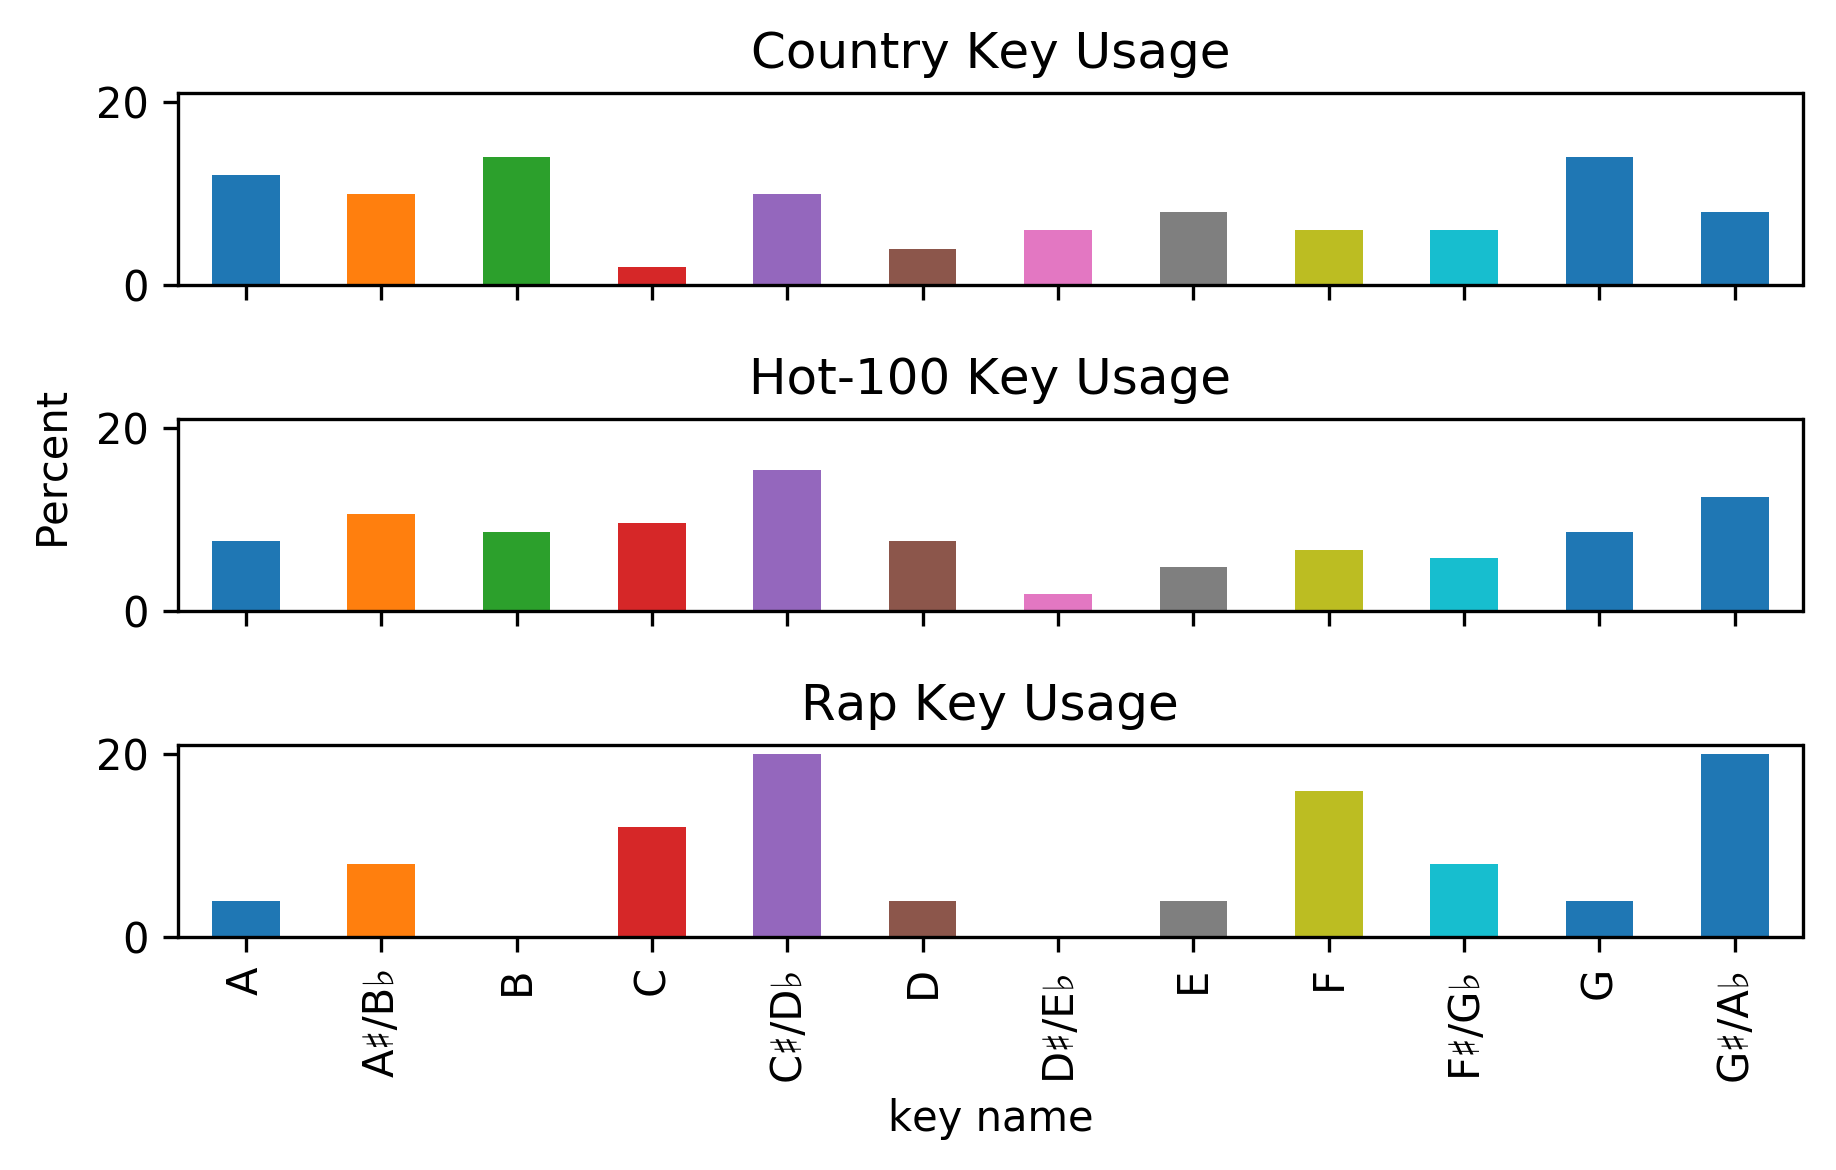

In [325]:
fig, ax = plt.subplots(3,1, dpi=300, sharex=True, sharey=True)
ax1 = genreUnstacked.xs('country').plot(kind='bar',ax=ax[0])
ax2 = genreUnstacked.xs('hot-100').plot(kind='bar',ax=ax[1])
ax3 = genreUnstacked.xs('rap').plot(kind='bar',ax=ax[2])
ax1.set_title('Country Key Usage')
ax2.set_title('Hot-100 Key Usage')
ax3.set_title('Rap Key Usage')
fig.text(x=0, y=0.6, s='Percent', ha='center', va='center', rotation='vertical')
plt.tight_layout()

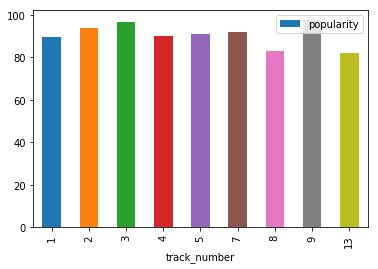

In [134]:
track_number = rap_tracks_df.groupby('track_number').mean()

track_number.plot( y='popularity', kind='bar')

In [ ]:
top_songs_df.to_csv('top_songs.csv')

In [28]:
slow_df = hot_features[hot_features['tempo']<= 120]
fast_df = hot_features[hot_features['tempo']> 120]

In [29]:
print(len(slow_df))
print(len(fast_df))

slow_df.head(100)

49
51


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
1,0.34900,https://api.spotify.com/v1/audio-analysis/0s3n...,0.511,239836,0.566,0s3nnoMeVWz3989MkNQiRf,0.000000,6,0.3400,-7.230,0,0.2000,83.903,4,https://api.spotify.com/v1/tracks/0s3nnoMeVWz3...,audio_features,spotify:track:0s3nnoMeVWz3989MkNQiRf,0.2180
3,0.05890,https://api.spotify.com/v1/audio-analysis/2G7V...,0.835,217925,0.626,2G7V7zsVDxg1yRsu7Ew9RJ,0.000060,1,0.3960,-5.833,1,0.1250,91.030,4,https://api.spotify.com/v1/tracks/2G7V7zsVDxg1...,audio_features,spotify:track:2G7V7zsVDxg1yRsu7Ew9RJ,0.3500
4,0.09890,https://api.spotify.com/v1/audio-analysis/1jo3...,0.892,253580,0.651,1jo3TwNGCXfNdB5uba3ZVv,0.000000,0,0.3710,-8.645,0,0.3780,105.814,4,https://api.spotify.com/v1/tracks/1jo3TwNGCXfN...,audio_features,spotify:track:1jo3TwNGCXfNdB5uba3ZVv,0.5990
8,0.01140,https://api.spotify.com/v1/audio-analysis/4S8d...,0.901,127947,0.522,4S8d14HvHb70ImctNgVzQQ,0.000000,2,0.2590,-8.304,1,0.3300,104.053,4,https://api.spotify.com/v1/tracks/4S8d14HvHb70...,audio_features,spotify:track:4S8d14HvHb70ImctNgVzQQ,0.3290
10,0.02360,https://api.spotify.com/v1/audio-analysis/5IaH...,0.884,232959,0.559,5IaHrVsrferBYDm0bDyABy,0.000000,0,0.1010,-7.442,1,0.1200,97.994,4,https://api.spotify.com/v1/tracks/5IaHrVsrferB...,audio_features,spotify:track:5IaHrVsrferBYDm0bDyABy,0.3420
13,0.21600,https://api.spotify.com/v1/audio-analysis/4zIO...,0.448,189467,0.612,4zIO3ilp5HvTeK3HJHxhMP,0.000000,2,0.0800,-6.106,1,0.0708,97.773,4,https://api.spotify.com/v1/tracks/4zIO3ilp5HvT...,audio_features,spotify:track:4zIO3ilp5HvTeK3HJHxhMP,0.2130
14,0.19100,https://api.spotify.com/v1/audio-analysis/2dpa...,0.687,214290,0.792,2dpaYNEQHiRxtZbfNsse99,0.000000,5,0.1670,-2.749,1,0.0452,100.015,4,https://api.spotify.com/v1/tracks/2dpaYNEQHiRx...,audio_features,spotify:track:2dpaYNEQHiRxtZbfNsse99,0.6710
17,0.21400,https://api.spotify.com/v1/audio-analysis/7nou...,0.717,217118,0.605,7noud145AHZGg74vpWOsCa,0.000000,11,0.1380,-5.680,0,0.0750,81.047,4,https://api.spotify.com/v1/tracks/7noud145AHZG...,audio_features,spotify:track:7noud145AHZGg74vpWOsCa,0.3870
18,0.09450,https://api.spotify.com/v1/audio-analysis/4hQ6...,0.601,207905,0.724,4hQ6UGyWQIGJmHSo0J88JW,0.000002,6,0.1200,-4.856,1,0.0486,102.061,4,https://api.spotify.com/v1/tracks/4hQ6UGyWQIGJ...,audio_features,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,0.5080
21,0.03500,https://api.spotify.com/v1/audio-analysis/6vN7...,0.964,142273,0.346,6vN77lE9LK6HP2DewaN6HZ,0.000000,5,0.1080,-9.309,0,0.5300,119.958,4,https://api.spotify.com/v1/tracks/6vN77lE9LK6H...,audio_features,spotify:track:6vN77lE9LK6HP2DewaN6HZ,0.5620


In [31]:
stats.ttest_ind(slow_df['popularity'], fast_df['popularity'])

KeyError: 'popularity'

In [36]:
happy_df = hot_df[hot_df['valence']>=0.5]
sad_df = hot_df[hot_df['valence']<=0.5]

print(len(happy_df))
print(len(sad_df))

36
64


In [57]:
dancy_split = 0.1

dancy_df = hot_df[hot_df['danceability']>= dancy_split]
nondancy_df = hot_df[hot_df['danceability']< dancy_split]

print(len(dancy_df))
print(len(nondancy_df))

49
51


In [58]:
stats.ttest_ind(dancy_df['Popularity'], nondancy_df['Popularity'])

Ttest_indResult(statistic=-0.9006530994203404, pvalue=0.36998078698489467)

In [35]:
stats.ttest_ind(happy_df['Popularity'], sad_df['Popularity'])

Ttest_indResult(statistic=-1.8289807981089075, pvalue=0.0704436394626824)

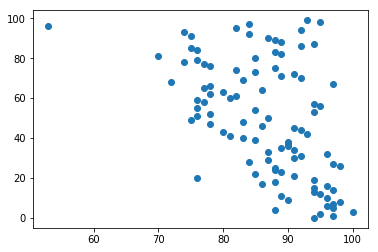

In [59]:
plt.scatter(hot_df.Popularity, hot_df.index)

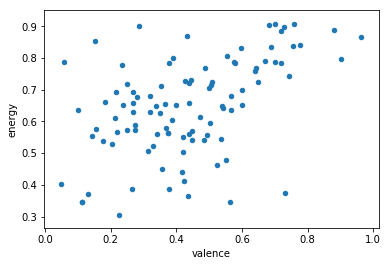

In [24]:
hot_df.plot("valence", "energy", kind='scatter')

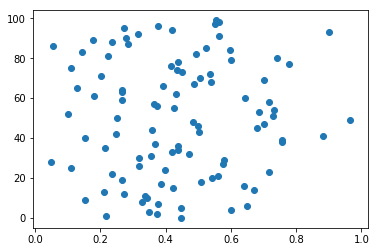

In [25]:
plt.scatter(hot_df['valence'], hot_df.index)

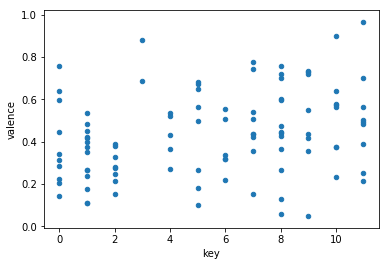

In [26]:
hot_df.plot("key", "valence", kind='scatter')

In [27]:
top_keys = hot_df.groupby('key').mean()
top_keys.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
key,,,,,,,,,,,,
0,0.249970,0.733500,222644.000000,0.614900,0.000034,0.151510,-6.431700,0.900000,0.171400,130.931100,4.100,0.395600
1,0.130789,0.728214,223110.785714,0.517286,0.000142,0.191643,-7.276143,0.857143,0.192671,137.370643,4.000,0.328857
2,0.160050,0.612750,204750.125000,0.659750,0.000004,0.126150,-5.825625,0.875000,0.133625,109.056125,4.125,0.283500
3,0.229400,0.561000,200480.000000,0.861500,0.000000,0.097300,-3.285500,0.500000,0.072050,163.837000,4.000,0.784000
4,0.160544,0.690000,198880.600000,0.626600,0.000588,0.194140,-6.879200,0.200000,0.067480,128.597400,4.000,0.426800


<BarContainer object of 12 artists>

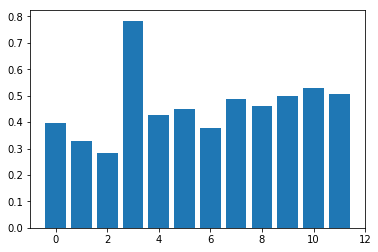

In [28]:
plt.bar(top_keys.index, top_keys.valence)

In [29]:
major_df = hot_df[hot_df['mode']==1]
# major_df = major_df.groupby('key').mean()
major_df

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.56800,https://api.spotify.com/v1/audio-analysis/6FRL...,0.851,235545,0.541,6FRLCMO5TUHTexlWo8ym1W,0.000000,0,0.1300,-6.825,1,0.0505,124.959,4,https://api.spotify.com/v1/tracks/6FRLCMO5TUHT...,audio_features,spotify:track:6FRLCMO5TUHTexlWo8ym1W,0.4480
2,0.35400,https://api.spotify.com/v1/audio-analysis/7dt6...,0.680,231267,0.563,7dt6x5M1jzdTEt8oCbisTK,0.000000,10,0.1360,-5.843,1,0.0454,145.028,4,https://api.spotify.com/v1/tracks/7dt6x5M1jzdT...,audio_features,spotify:track:7dt6x5M1jzdTEt8oCbisTK,0.3740
3,0.05890,https://api.spotify.com/v1/audio-analysis/2G7V...,0.835,217925,0.626,2G7V7zsVDxg1yRsu7Ew9RJ,0.000060,1,0.3960,-5.833,1,0.1250,91.030,4,https://api.spotify.com/v1/tracks/2G7V7zsVDxg1...,audio_features,spotify:track:2G7V7zsVDxg1yRsu7Ew9RJ,0.3500
5,0.00513,https://api.spotify.com/v1/audio-analysis/2xLM...,0.834,312820,0.730,2xLMifQCjDGFmkHkpNLD9h,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,audio_features,spotify:track:2xLMifQCjDGFmkHkpNLD9h,0.4460
7,0.08800,https://api.spotify.com/v1/audio-analysis/2E12...,0.931,179405,0.387,2E124GmJRnBJuXbTb4cPUB,0.000000,1,0.1360,-9.127,1,0.4120,125.978,4,https://api.spotify.com/v1/tracks/2E124GmJRnBJ...,audio_features,spotify:track:2E124GmJRnBJuXbTb4cPUB,0.3760
8,0.01140,https://api.spotify.com/v1/audio-analysis/4S8d...,0.901,127947,0.522,4S8d14HvHb70ImctNgVzQQ,0.000000,2,0.2590,-8.304,1,0.3300,104.053,4,https://api.spotify.com/v1/tracks/4S8d14HvHb70...,audio_features,spotify:track:4S8d14HvHb70ImctNgVzQQ,0.3290
10,0.02360,https://api.spotify.com/v1/audio-analysis/5IaH...,0.884,232959,0.559,5IaHrVsrferBYDm0bDyABy,0.000000,0,0.1010,-7.442,1,0.1200,97.994,4,https://api.spotify.com/v1/tracks/5IaHrVsrferB...,audio_features,spotify:track:5IaHrVsrferBYDm0bDyABy,0.3420
11,0.09560,https://api.spotify.com/v1/audio-analysis/45Eg...,0.708,201707,0.648,45Egmo7icyopuzJN0oMEdk,0.000000,6,0.1340,-5.626,1,0.0449,143.955,4,https://api.spotify.com/v1/tracks/45Egmo7icyop...,audio_features,spotify:track:45Egmo7icyopuzJN0oMEdk,0.3380
13,0.21600,https://api.spotify.com/v1/audio-analysis/4zIO...,0.448,189467,0.612,4zIO3ilp5HvTeK3HJHxhMP,0.000000,2,0.0800,-6.106,1,0.0708,97.773,4,https://api.spotify.com/v1/tracks/4zIO3ilp5HvT...,audio_features,spotify:track:4zIO3ilp5HvTeK3HJHxhMP,0.2130
14,0.19100,https://api.spotify.com/v1/audio-analysis/2dpa...,0.687,214290,0.792,2dpaYNEQHiRxtZbfNsse99,0.000000,5,0.1670,-2.749,1,0.0452,100.015,4,https://api.spotify.com/v1/tracks/2dpaYNEQHiRx...,audio_features,spotify:track:2dpaYNEQHiRxtZbfNsse99,0.6710


<BarContainer object of 70 artists>

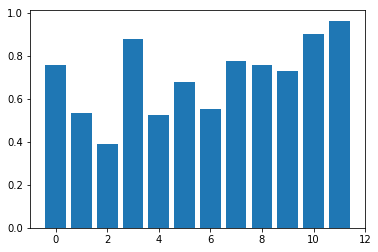

In [30]:
plt.bar(major_df['key'], major_df['valence'])

In [31]:
Cmaj = major_df[major_df['key']==0]
# Csharp

key_data=[]
for key in range(0,12):
    key_df = major_df[major_df['key']==key]
    key_data.append(key_df['valence'])


In [32]:
print(key_data)

[0     0.448
10    0.342
16    0.639
39    0.756
71    0.203
81    0.224
83    0.144
87    0.286
92    0.315
Name: valence, dtype: float64, 3     0.350
7     0.376
19    0.268
25    0.112
59    0.266
72    0.535
73    0.449
75    0.112
76    0.418
88    0.237
89    0.177
94    0.420
Name: valence, dtype: float64, 8     0.329
13    0.213
42    0.249
66    0.391
90    0.280
95    0.274
96    0.378
Name: valence, dtype: float64, 41    0.881
Name: valence, dtype: float64, 85    0.523
Name: valence, dtype: float64, 14    0.671
45    0.681
52    0.100
61    0.182
63    0.268
Name: valence, dtype: float64, 11    0.338
18    0.508
99    0.555
Name: valence, dtype: float64, 15    0.422
20    0.542
36    0.437
44    0.357
70    0.507
74    0.436
77    0.778
80    0.742
Name: valence, dtype: float64, 5     0.4460
32    0.4730
34    0.4390
38    0.7570
55    0.4270
57    0.3640
64    0.2670
79    0.6000
84    0.5960
86    0.0564
Name: valence, dtype: float64, 33    0.419
51    0.728
54    0.732
58

In [33]:
stats.f_oneway(key_data[0],key_data[-1])

F_onewayResult(statistic=4.958488251303191, pvalue=0.04587688112640743)

In [18]:
song_test = 'I wanna dance with somebody (who loves me)'

i_wanna_dance_id = sp.search(song_test)['tracks']['items'][0]['id']

pprint(i_wanna_dance_id)

whitney_analysis = sp.audio_analysis(i_wanna_dance_id)

'2tUBqZG2AbRi7Q0BIrVrEj'


In [19]:
pprint(whitney_analysis)

{'bars': [{'confidence': 0.065, 'duration': 1.99431, 'start': 0.70307},
          {'confidence': 0.686, 'duration': 2.01989, 'start': 2.69738},
          {'confidence': 0.63, 'duration': 2.01885, 'start': 4.71727},
          {'confidence': 0.635, 'duration': 2.02171, 'start': 6.73612},
          {'confidence': 0.543, 'duration': 2.01641, 'start': 8.75782},
          {'confidence': 0.58, 'duration': 2.01753, 'start': 10.77423},
          {'confidence': 0.712, 'duration': 2.02408, 'start': 12.79177},
          {'confidence': 0.354, 'duration': 2.02123, 'start': 14.81584},
          {'confidence': 0.698, 'duration': 2.01894, 'start': 16.83708},
          {'confidence': 0.837, 'duration': 2.01839, 'start': 18.85601},
          {'confidence': 0.865, 'duration': 2.01804, 'start': 20.8744},
          {'confidence': 0.188, 'duration': 2.02294, 'start': 22.89244},
          {'confidence': 0.858, 'duration': 2.01762, 'start': 24.91538},
          {'confidence': 0.457, 'duration': 2.01876, 'start

               'start': 2.81619,
               'timbre': [34.357,
                          82.497,
                          45.67,
                          170.065,
                          68.286,
                          -95.108,
                          37.071,
                          25.216,
                          48.389,
                          9.029,
                          -61.213,
                          -21.803]},
              {'confidence': 1.0,
               'duration': 0.26118,
               'loudness_max': -8.859,
               'loudness_max_time': 0.01701,
               'loudness_start': -45.587,
               'pitches': [0.632,
                           1.0,
                           0.685,
                           0.079,
                           0.092,
                           0.274,
                           0.22,
                           0.46,
                           0.301,
                           0.15,
                        

               'loudness_start': -8.32,
               'pitches': [0.612,
                           0.729,
                           0.522,
                           0.416,
                           0.549,
                           0.948,
                           0.927,
                           0.82,
                           0.704,
                           0.764,
                           1.0,
                           0.893],
               'start': 12.21923,
               'timbre': [54.054,
                          63.659,
                          29.325,
                          -0.329,
                          53.908,
                          -31.19,
                          26.641,
                          53.376,
                          14.662,
                          10.838,
                          -14.384,
                          -1.643]},
              {'confidence': 0.032,
               'duration': 0.11642,
               'loudness_max': -8.561

                          -22.152,
                          -26.285,
                          -26.098,
                          6.843,
                          26.498,
                          -6.131,
                          -33.54]},
              {'confidence': 0.65,
               'duration': 0.09388,
               'loudness_max': -3.958,
               'loudness_max_time': 0.03088,
               'loudness_start': -10.867,
               'pitches': [1.0,
                           0.834,
                           0.069,
                           0.116,
                           0.165,
                           0.232,
                           0.568,
                           0.346,
                           0.623,
                           0.617,
                           0.884,
                           0.125],
               'start': 24.89701,
               'timbre': [53.641,
                          79.202,
                          24.882,
                  

                           0.343,
                           1.0,
                           0.193,
                           0.107,
                           0.055,
                           0.206,
                           0.06],
               'start': 37.77297,
               'timbre': [46.197,
                          58.363,
                          -22.72,
                          -4.97,
                          33.856,
                          -38.273,
                          -67.361,
                          14.853,
                          2.104,
                          19.003,
                          -30.493,
                          -4.712]},
              {'confidence': 0.986,
               'duration': 0.18054,
               'loudness_max': -7.717,
               'loudness_max_time': 0.11204,
               'loudness_start': -26.616,
               'pitches': [0.024,
                           0.08,
                           0.025,
                    

              {'confidence': 0.328,
               'duration': 0.24444,
               'loudness_max': -6.388,
               'loudness_max_time': 0.05944,
               'loudness_start': -9.835,
               'pitches': [0.524,
                           0.218,
                           0.142,
                           0.147,
                           0.193,
                           0.507,
                           0.195,
                           0.13,
                           0.138,
                           0.1,
                           0.347,
                           1.0],
               'start': 50.60222,
               'timbre': [51.07,
                          140.685,
                          27.221,
                          -4.551,
                          -2.067,
                          -25.342,
                          8.986,
                          14.058,
                          8.239,
                          8.188,
                          -

               'start': 63.26853,
               'timbre': [49.84,
                          132.245,
                          16.18,
                          -30.174,
                          22.594,
                          -39.156,
                          6.273,
                          3.409,
                          1.337,
                          -0.324,
                          1.346,
                          4.82]},
              {'confidence': 0.233,
               'duration': 0.11052,
               'loudness_max': -9.84,
               'loudness_max_time': 0.0431,
               'loudness_start': -12.975,
               'pitches': [0.217,
                           0.651,
                           0.354,
                           0.248,
                           0.459,
                           0.587,
                           1.0,
                           0.665,
                           0.564,
                           0.496,
                           

               'loudness_start': -18.436,
               'pitches': [0.404,
                           0.322,
                           0.148,
                           0.044,
                           0.03,
                           0.072,
                           0.294,
                           0.105,
                           0.072,
                           0.063,
                           0.104,
                           1.0],
               'start': 77.4039,
               'timbre': [52.022,
                          90.042,
                          41.949,
                          21.86,
                          17.17,
                          -26.044,
                          52.69,
                          16.89,
                          -5.233,
                          21.487,
                          8.006,
                          2.355]},
              {'confidence': 0.017,
               'duration': 0.1161,
               'loudness_max': -8.91,
     

               'timbre': [51.037,
                          125.518,
                          96.059,
                          15.129,
                          50.704,
                          16.599,
                          49.361,
                          0.07,
                          11.626,
                          17.243,
                          17.835,
                          -15.205]},
              {'confidence': 0.201,
               'duration': 0.3829,
               'loudness_max': -7.129,
               'loudness_max_time': 0.01028,
               'loudness_start': -10.047,
               'pitches': [0.206,
                           0.371,
                           0.335,
                           1.0,
                           0.262,
                           0.255,
                           0.283,
                           0.332,
                           0.441,
                           0.338,
                           0.906,
                     

                           0.638,
                           0.131,
                           0.139,
                           0.52,
                           0.285,
                           0.137,
                           0.17,
                           0.138,
                           0.103,
                           0.158],
               'start': 102.14522,
               'timbre': [46.551,
                          115.14,
                          -80.585,
                          24.737,
                          63.443,
                          -61.555,
                          -17.689,
                          33.151,
                          24.099,
                          -2.342,
                          -23.932,
                          6.242]},
              {'confidence': 0.756,
               'duration': 0.10458,
               'loudness_max': -12.143,
               'loudness_max_time': 0.023,
               'loudness_start': -21.966,
               '

               'loudness_max': -14.498,
               'loudness_max_time': 0.03658,
               'loudness_start': -18.532,
               'pitches': [0.037,
                           0.098,
                           0.133,
                           0.699,
                           1.0,
                           0.05,
                           0.013,
                           0.041,
                           0.024,
                           0.028,
                           0.087,
                           0.057],
               'start': 113.98735,
               'timbre': [42.849,
                          -21.476,
                          -46.217,
                          -17.822,
                          137.016,
                          -31.536,
                          -8.763,
                          0.022,
                          -5.915,
                          -16.727,
                          -18.502,
                          12.819]},
              {'

                           0.174,
                           0.067,
                           0.056,
                           0.079,
                           1.0],
               'start': 128.40603,
               'timbre': [50.591,
                          48.311,
                          1.749,
                          -22.456,
                          49.356,
                          -70.415,
                          18.096,
                          9.18,
                          21.513,
                          17.141,
                          -21.89,
                          -7.253]},
              {'confidence': 0.286,
               'duration': 0.52181,
               'loudness_max': -8.045,
               'loudness_max_time': 0.03057,
               'loudness_start': -11.902,
               'pitches': [0.358,
                           1.0,
                           0.384,
                           0.207,
                           0.15,
                      

              {'confidence': 0.567,
               'duration': 0.09288,
               'loudness_max': -15.846,
               'loudness_max_time': 0.00915,
               'loudness_start': -21.358,
               'pitches': [0.133,
                           0.871,
                           0.284,
                           0.542,
                           0.118,
                           0.313,
                           0.945,
                           0.349,
                           1.0,
                           0.21,
                           0.234,
                           0.282],
               'start': 143.44122,
               'timbre': [40.934,
                          142.013,
                          22.299,
                          18.549,
                          157.422,
                          -86.247,
                          -5.366,
                          19.55,
                          -25.278,
                          -16.812,
                

               'timbre': [48.401,
                          26.573,
                          39.846,
                          -24.136,
                          96.639,
                          -14.78,
                          -47.106,
                          -18.76,
                          3.333,
                          27.559,
                          -5.864,
                          -24.294]},
              {'confidence': 0.472,
               'duration': 0.21469,
               'loudness_max': -8.172,
               'loudness_max_time': 0.01469,
               'loudness_start': -12.908,
               'pitches': [0.295,
                           1.0,
                           0.547,
                           0.026,
                           0.028,
                           0.117,
                           0.181,
                           0.115,
                           0.108,
                           0.057,
                           0.106,
                  

              {'confidence': 1.0,
               'duration': 0.37737,
               'loudness_max': -9.87,
               'loudness_max_time': 0.01857,
               'loudness_start': -31.429,
               'pitches': [0.206,
                           1.0,
                           0.269,
                           0.065,
                           0.048,
                           0.137,
                           0.101,
                           0.137,
                           0.287,
                           0.1,
                           0.125,
                           0.092],
               'start': 166.2722,
               'timbre': [43.773,
                          86.631,
                          -68.972,
                          47.514,
                          39.55,
                          -50.991,
                          -12.55,
                          3.187,
                          -10.155,
                          10.251,
                         

                          -29.159,
                          -4.849,
                          -14.106,
                          11.352,
                          8.856,
                          -25.07,
                          30.902]},
              {'confidence': 0.648,
               'duration': 0.51079,
               'loudness_max': -5.019,
               'loudness_max_time': 0.05405,
               'loudness_start': -11.155,
               'pitches': [0.178,
                           0.133,
                           0.245,
                           0.278,
                           0.209,
                           0.336,
                           0.227,
                           0.085,
                           0.173,
                           0.293,
                           1.0,
                           0.752],
               'start': 177.88798,
               'timbre': [53.055,
                          101.456,
                          35.497,
                

                           0.29,
                           0.251,
                           0.371,
                           0.587,
                           0.31,
                           0.254,
                           0.408],
               'start': 191.87791,
               'timbre': [53.868,
                          128.855,
                          80.104,
                          -2.704,
                          31.393,
                          -30.517,
                          71.155,
                          18.92,
                          -15.01,
                          -8.213,
                          -1.322,
                          50.904]},
              {'confidence': 0.531,
               'duration': 0.32481,
               'loudness_max': -0.54,
               'loudness_max_time': 0.08846,
               'loudness_start': -5.99,
               'pitches': [0.266,
                           0.362,
                           0.225,
                    

              {'confidence': 0.464,
               'duration': 0.24961,
               'loudness_max': -9.042,
               'loudness_max_time': 0.04347,
               'loudness_start': -14.393,
               'pitches': [0.391,
                           0.248,
                           0.283,
                           0.364,
                           0.259,
                           0.413,
                           0.244,
                           0.23,
                           0.218,
                           0.398,
                           1.0,
                           0.37],
               'start': 203.90036,
               'timbre': [48.871,
                          85.991,
                          68.765,
                          28.952,
                          44.763,
                          -31.705,
                          44.274,
                          27.405,
                          -12.182,
                          25.488,
                    

                           0.57,
                           0.198],
               'start': 219.04009,
               'timbre': [40.064,
                          98.852,
                          -7.308,
                          15.436,
                          62.619,
                          -39.878,
                          8.623,
                          5.901,
                          -31.808,
                          -16.218,
                          -18.404,
                          -6.019]},
              {'confidence': 0.901,
               'duration': 0.12816,
               'loudness_max': -11.777,
               'loudness_max_time': 0.02338,
               'loudness_start': -25.553,
               'pitches': [1.0,
                           0.819,
                           0.081,
                           0.1,
                           0.155,
                           0.241,
                           0.304,
                           0.295,
                  

               'pitches': [0.058,
                           0.062,
                           0.064,
                           0.054,
                           0.092,
                           0.317,
                           0.405,
                           0.446,
                           1.0,
                           0.194,
                           0.124,
                           0.078],
               'start': 231.02113,
               'timbre': [45.007,
                          43.05,
                          -38.867,
                          23.214,
                          46.036,
                          -34.212,
                          3.538,
                          26.792,
                          -2.654,
                          11.569,
                          2.954,
                          -0.24]},
              {'confidence': 0.564,
               'duration': 0.12136,
               'loudness_max': -12.099,
               'loudness_max_time': 0.

               'loudness_max_time': 0.04719,
               'loudness_start': -14.235,
               'pitches': [0.374,
                           0.29,
                           0.364,
                           0.333,
                           0.268,
                           0.327,
                           0.421,
                           0.824,
                           1.0,
                           0.337,
                           0.35,
                           0.398],
               'start': 244.14032,
               'timbre': [51.775,
                          98.908,
                          72.13,
                          29.023,
                          39.969,
                          -5.596,
                          17.837,
                          20.324,
                          28.583,
                          18.146,
                          -26.906,
                          -23.477]},
              {'confidence': 0.695,
               'duration':

               'pitches': [1.0,
                           0.305,
                           0.115,
                           0.131,
                           0.194,
                           0.349,
                           0.203,
                           0.13,
                           0.151,
                           0.099,
                           0.112,
                           0.356],
               'start': 255.6459,
               'timbre': [53.117,
                          93.052,
                          9.421,
                          -6.909,
                          33.096,
                          -35.215,
                          4.925,
                          6.202,
                          0.685,
                          6.012,
                          1.782,
                          8.732]},
              {'confidence': 0.571,
               'duration': 0.27283,
               'loudness_max': -4.074,
               'loudness_max_time': 0.04005,


                           0.57,
                           0.604,
                           0.634],
               'start': 266.75084,
               'timbre': [51.503,
                          117.022,
                          33.642,
                          40.846,
                          31.987,
                          10.618,
                          14.445,
                          9.675,
                          8.35,
                          18.278,
                          -13.719,
                          -1.774]},
              {'confidence': 0.763,
               'duration': 0.37161,
               'loudness_max': -10.418,
               'loudness_max_time': 0.00757,
               'loudness_start': -18.75,
               'pitches': [0.279,
                           0.15,
                           0.131,
                           0.1,
                           0.168,
                           1.0,
                           0.384,
                       

                          16.669,
                          -30.788,
                          25.37,
                          -45.154,
                          13.41,
                          12.552,
                          5.442,
                          -8.114,
                          5.547,
                          -2.241]},
              {'confidence': 0.16,
               'duration': 0.11642,
               'loudness_max': -19.427,
               'loudness_max_time': 0.01864,
               'loudness_start': -22.071,
               'pitches': [0.305,
                           0.148,
                           0.101,
                           0.211,
                           0.126,
                           0.125,
                           0.292,
                           1.0,
                           0.339,
                           0.144,
                           0.223,
                           0.053],
               'start': 281.67501,
               'timb

            {'confidence': 0.352, 'duration': 0.25294, 'start': 251.6336},
            {'confidence': 0.352, 'duration': 0.25294, 'start': 251.88655},
            {'confidence': 0.218, 'duration': 0.25226, 'start': 252.13949},
            {'confidence': 0.218, 'duration': 0.25226, 'start': 252.39175},
            {'confidence': 0.327, 'duration': 0.25293, 'start': 252.64401},
            {'confidence': 0.327, 'duration': 0.25293, 'start': 252.89694},
            {'confidence': 0.505, 'duration': 0.2536, 'start': 253.14986},
            {'confidence': 0.505, 'duration': 0.2536, 'start': 253.40346},
            {'confidence': 0.714, 'duration': 0.25203, 'start': 253.65705},
            {'confidence': 0.714, 'duration': 0.25203, 'start': 253.90908},
            {'confidence': 0.717, 'duration': 0.25147, 'start': 254.16111},
            {'confidence': 0.717, 'duration': 0.25147, 'start': 254.41257},
            {'confidence': 0.53, 'duration': 0.25304, 'start': 254.66404},
            {'co

In [20]:
whitney_sections = pd.DataFrame(whitney_analysis['sections'])
whitney_sections.head()

,confidence,duration,key,key_confidence,loudness,mode,mode_confidence,start,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1.000,5.22251,6,0.122,-15.317,1,0.454,0.00000,119.382,0.860,4,1.0
1,0.685,28.27182,1,0.000,-10.269,1,0.000,5.22251,118.838,0.590,4,1.0
2,0.606,16.16181,6,0.365,-9.916,1,0.427,33.49433,118.691,0.537,4,1.0
3,0.532,14.64028,6,0.221,-8.709,1,0.564,49.65614,118.901,0.534,4,1.0
4,0.297,33.83390,6,0.813,-8.319,1,0.655,64.29642,118.800,0.504,4,1.0


In [21]:
# Remove data with zero confidence
whitney_confident = whitney_sections[whitney_sections['key_confidence'] != 0]

In [22]:
whitney_confident.head()

,confidence,duration,key,key_confidence,loudness,mode,mode_confidence,start,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1.000,5.22251,6,0.122,-15.317,1,0.454,0.00000,119.382,0.860,4,1.0
2,0.606,16.16181,6,0.365,-9.916,1,0.427,33.49433,118.691,0.537,4,1.0
3,0.532,14.64028,6,0.221,-8.709,1,0.564,49.65614,118.901,0.534,4,1.0
4,0.297,33.83390,6,0.813,-8.319,1,0.655,64.29642,118.800,0.504,4,1.0
5,0.707,17.66914,8,0.670,-11.009,0,0.607,98.13032,118.887,0.577,4,1.0


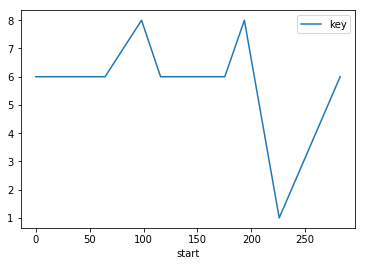

In [30]:
whitney_plot = whitney_confident.plot('start','key')

In [32]:
whitney_segments = pd.DataFrame(whitney_analysis['segments'])
whitney_segments

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre
0,0.000,0.64644,NaN,-60.000,0.00000,-60.000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.00000,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
1,1.000,0.14902,NaN,-12.073,0.04390,-60.000,"[1.0, 0.894, 0.073, 0.054, 0.125, 0.132, 0.262...",0.64644,"[29.482, 73.471, -54.033, -120.08, 12.64, 275...."
2,0.864,0.12231,NaN,-17.039,0.03687,-29.753,"[0.532, 1.0, 0.318, 0.278, 0.268, 0.328, 0.269...",0.79546,"[37.985, 105.028, 35.462, 66.054, 7.279, -23.3..."
3,0.738,0.25492,NaN,-17.170,0.03666,-28.437,"[0.811, 0.885, 0.864, 0.575, 0.669, 0.82, 0.70...",0.91778,"[34.761, 150.311, 92.339, 131.822, 56.826, -21..."
4,1.000,0.48748,NaN,-20.388,0.03813,-37.281,"[0.851, 0.631, 0.834, 0.776, 0.785, 0.646, 0.7...",1.17270,"[27.653, 178.174, 96.492, 244.686, 96.507, 12...."
5,1.000,0.26902,NaN,-11.552,0.01771,-56.767,"[0.677, 1.0, 0.653, 0.086, 0.072, 0.269, 0.263...",1.66018,"[35.315, 74.046, -118.993, 142.181, -56.381, -..."
6,1.000,0.12549,NaN,-15.498,0.00650,-42.798,"[0.192, 0.298, 0.1, 0.072, 0.029, 0.044, 0.054...",1.92921,"[35.007, 108.055, 98.948, 119.503, 100.358, -1..."
7,0.829,0.11655,NaN,-17.986,0.00864,-32.231,"[0.025, 0.171, 0.073, 0.044, 0.016, 0.024, 0.0...",2.05469,"[35.284, 150.653, 189.102, 110.417, 158.206, -..."
8,0.659,0.13932,NaN,-21.164,0.04861,-29.153,"[0.95, 0.622, 0.697, 0.751, 0.623, 0.75, 0.519...",2.17125,"[34.039, 175.519, 177.6, 84.066, 122.561, 2.49..."
9,0.777,0.24934,NaN,-17.114,0.00744,-31.021,"[0.075, 0.159, 0.13, 0.098, 0.078, 0.063, 0.07...",2.31057,"[34.403, 137.664, 172.697, 154.492, 145.47, -9..."
